# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [21]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [22]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [23]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [24]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## Data Exploration

In [5]:
# Check for missing values in each dataset
print("Portfolio missing values:")
print(portfolio.isnull().sum())
print("\nProfile missing values:")
print(profile.isnull().sum())
print("\nTranscript missing values:")
print(transcript.isnull().sum())

# Check unique values and distributions
print("\nOffer types:", portfolio['offer_type'].unique())
print("Gender distribution:", profile['gender'].value_counts(dropna=False))
print("Age statistics:", profile['age'].describe())
print("Events in transcript:", transcript['event'].value_counts())

# Extract offer_id and amount from the 'value' dictionary column in transcript
def extract_values(row):
    if row['event'] == 'transaction':
        return pd.Series([None, row['value'].get('amount')])
    else:
        return pd.Series([row['value'].get('offer id'), None])

transcript[['offer_id', 'amount']] = transcript.apply(extract_values, axis=1)

Portfolio missing values:
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Profile missing values:
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Transcript missing values:
person    0
event     0
value     0
time      0
dtype: int64

Offer types: ['bogo' 'informational' 'discount']
Gender distribution: gender
M       8484
F       6129
None    2175
O        212
Name: count, dtype: int64
Age statistics: count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64
Events in transcript: event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64


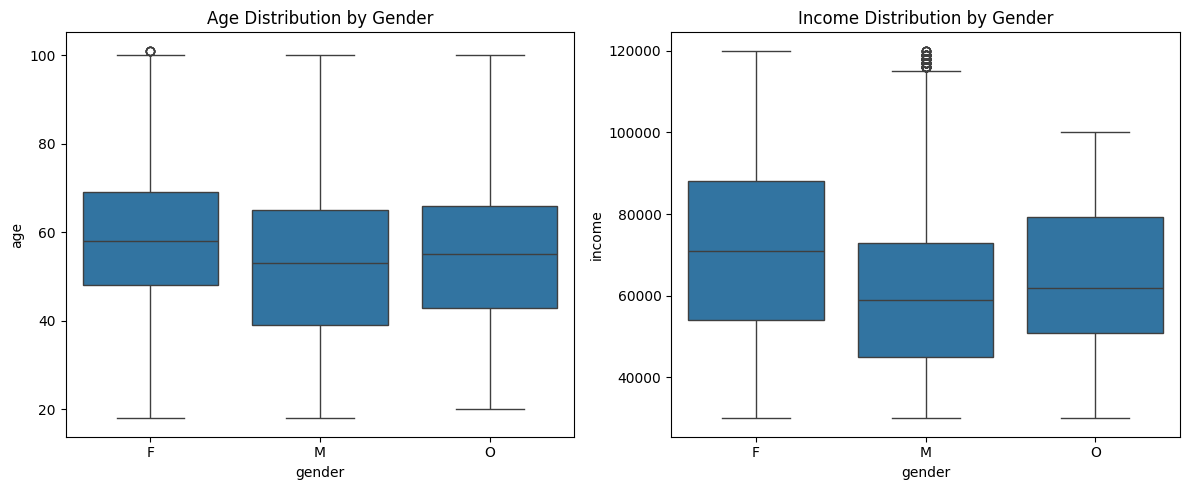

In [6]:
# Convert became_member_on to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['membership_days'] = (pd.Timestamp('2018-07-31') - profile['became_member_on']).dt.days

# Handle missing gender and age values
# Looking at age=118, it seems to be a placeholder for missing values
profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
profile['gender'] = profile['gender'].fillna('Unknown')

# Visualize age and income by gender
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='gender', y='age', data=profile[profile['age'].notnull()])
plt.title('Age Distribution by Gender')

plt.subplot(1, 2, 2)
sns.boxplot(x='gender', y='income', data=profile[profile['income'].notnull()])
plt.title('Income Distribution by Gender')
plt.tight_layout()
plt.show()

Portfolio shape: (10, 6)
Profile shape: (17000, 6)
Transcript shape: (306534, 6)

Missing values in portfolio:
reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

Missing values in profile:
gender                 0
age                 2175
id                     0
became_member_on       0
income              2175
membership_days        0
dtype: int64

Missing values in transcript:
person           0
event            0
value            0
time             0
offer_id    172532
amount      167581
dtype: int64

Offer types distribution:
offer_type
bogo             4
discount         4
informational    2
Name: count, dtype: int64

Channels distribution:
email     10
mobile     9
web        8
social     6
Name: count, dtype: int64

Summary statistics for portfolio numerical columns:
       difficulty     reward   duration
count   10.000000  10.000000  10.000000
mean     7.700000   4.200000   6.500000
std      5.831905   3.583915   2.32

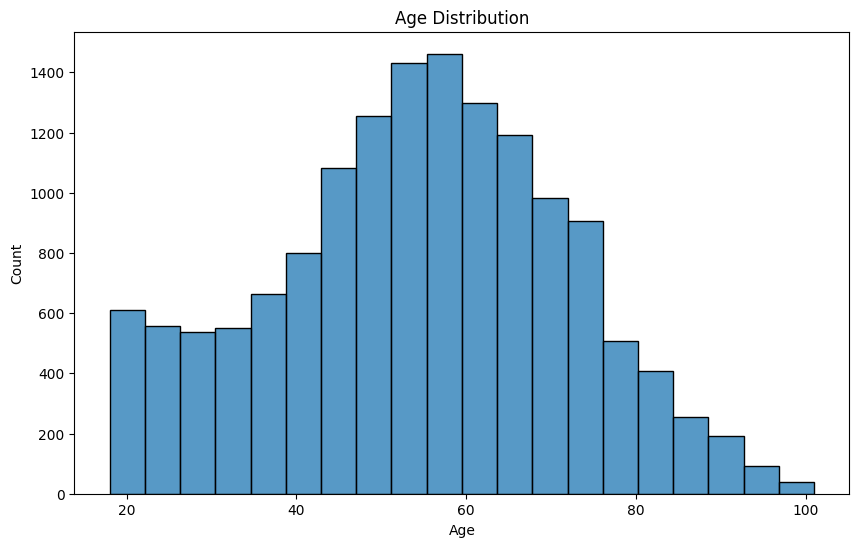


Income statistics:
count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

Event types distribution:
event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

Transaction amount statistics:
count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

Events distribution over time:
event      offer completed  offer received  offer viewed  transaction
time_week                                                            
(0, 7]                5073           12669         10198        26975
(7, 14]               5642           12711         10014        29645
(14, 21]             10971           25482     

/tmp/ipykernel_13/441257597.py:198: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_metrics = user_df.groupby('age_group')[['view_rate', 'completion_rate']].mean()
/tmp/ipykernel_13/441257597.py:202: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_metrics = user_df.groupby('income_group')[['view_rate', 'completion_rate']].mean()


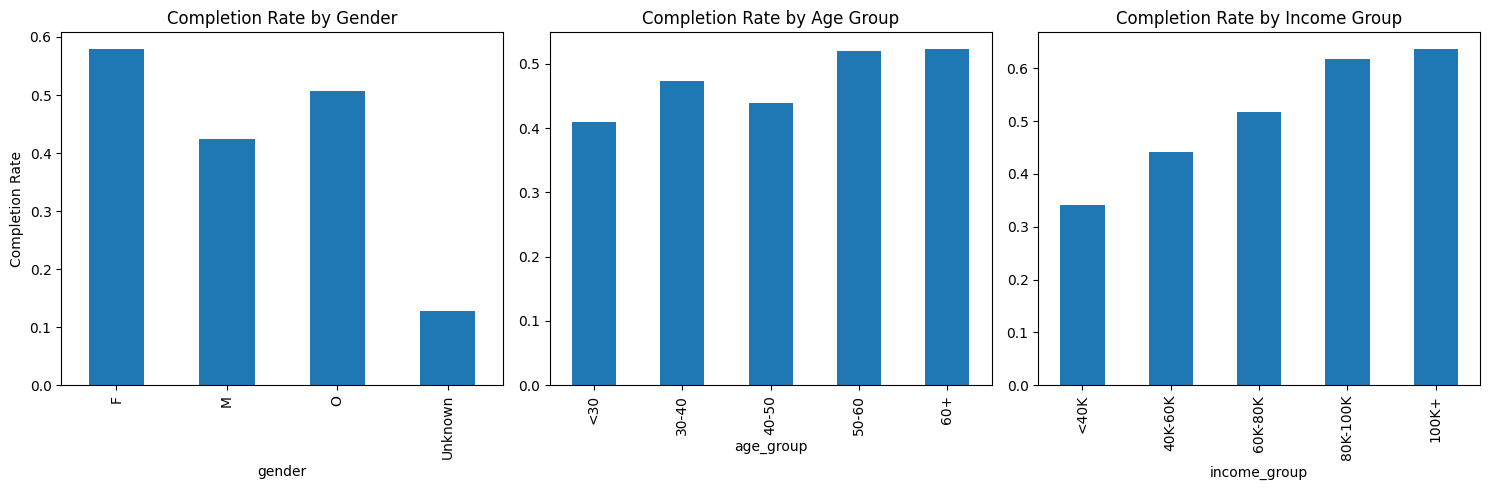

In [20]:
# 1. Basic overview of the datasets
print("Portfolio shape:", portfolio.shape)
print("Profile shape:", profile.shape)
print("Transcript shape:", transcript.shape)

# 2. Portfolio analysis
print("\nOffer types distribution:")
print(portfolio['offer_type'].value_counts())

print("\nChannels distribution:")
channels = []
for channel_list in portfolio['channels']:
    channels.extend(channel_list)
print(pd.Series(channels).value_counts())

print("\nSummary statistics for portfolio numerical columns:")
print(portfolio[['difficulty', 'reward', 'duration']].describe())

# 4. Profile analysis
print("\nGender distribution:")
print(profile['gender'].value_counts(dropna=False))

# Convert membership date to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['membership_year'] = profile['became_member_on'].dt.year

print("\nMembership year distribution:")
print(profile['membership_year'].value_counts().sort_index())

# Clean age data (replace 118 with NaN)
profile['age_clean'] = profile['age'].replace(118, np.nan)

print("\nAge statistics:")
print(profile['age_clean'].describe())

# Visualize age distribution
plt.figure(figsize=(10, 6))
sns.histplot(profile['age_clean'].dropna(), bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.show()

print("\nIncome statistics:")
print(profile['income'].describe())

# 5. Transcript analysis
print("\nEvent types distribution:")
print(transcript['event'].value_counts())

# Extract offer ids and amounts
offer_ids = []
amounts = []

for idx, row in transcript.iterrows():
    if row['event'] == 'transaction':
        offer_ids.append(None)
        amounts.append(row['value'].get('amount'))
    else:
        offer_ids.append(row['value'].get('offer id'))
        amounts.append(None)

transcript['offer_id'] = offer_ids
transcript['amount'] = amounts

print("\nTransaction amount statistics:")
print(transcript[transcript['event'] == 'transaction']['amount'].describe())

# Create time bins to see distribution of events over time
transcript['time_day'] = transcript['time'] // 24
time_bins = [0, 7, 14, 21, 28, 35]  # Weekly bins
transcript['time_week'] = pd.cut(transcript['time_day'], time_bins)

print("\nEvents distribution over time:")
print(pd.crosstab(transcript['time_week'], transcript['event']))

# 6. Offer effectiveness analysis
# Count offers received, viewed, and completed
offers_received = transcript[transcript['event'] == 'offer received']['offer_id'].value_counts()
offers_viewed = transcript[transcript['event'] == 'offer viewed']['offer_id'].value_counts()
offers_completed = transcript[transcript['event'] == 'offer completed']['offer_id'].value_counts()

offer_counts = pd.DataFrame({
    'received': offers_received,
    'viewed': offers_viewed,
    'completed': offers_completed
}).fillna(0)

offer_counts['view_rate'] = offer_counts['viewed'] / offer_counts['received']
offer_counts['completion_rate'] = offer_counts['completed'] / offer_counts['received']

# Merge with portfolio for offer details
offer_counts = offer_counts.reset_index().rename(columns={'index': 'offer_id'})
offer_counts = offer_counts.merge(portfolio, left_on='offer_id', right_on='id', how='left')

print("\nOffer effectiveness metrics:")
print(offer_counts[['offer_id', 'offer_type', 'received', 'viewed', 'completed', 'view_rate', 'completion_rate']])

# 7. User behavior analysis
# Count unique users who received, viewed, and completed each offer
user_received = transcript[transcript['event'] == 'offer received'].groupby('offer_id')['person'].nunique()
user_viewed = transcript[transcript['event'] == 'offer viewed'].groupby('offer_id')['person'].nunique()
user_completed = transcript[transcript['event'] == 'offer completed'].groupby('offer_id')['person'].nunique()

user_counts = pd.DataFrame({
    'users_received': user_received,
    'users_viewed': user_viewed,
    'users_completed': user_completed
}).fillna(0)

user_counts['user_view_rate'] = user_counts['users_viewed'] / user_counts['users_received']
user_counts['user_completion_rate'] = user_counts['users_completed'] / user_counts['users_received']

# Merge with portfolio
user_counts = user_counts.reset_index().rename(columns={'index': 'offer_id'})
user_counts = user_counts.merge(portfolio, left_on='offer_id', right_on='id', how='left')

print("\nUser response rates by offer:")
print(user_counts[['offer_id', 'offer_type', 'users_received', 'users_viewed', 'users_completed', 
                  'user_view_rate', 'user_completion_rate']])

# 8. Transaction analysis
transactions = transcript[transcript['event'] == 'transaction']
print("\nTransaction statistics:")
print(f"Total transactions: {len(transactions)}")
print(f"Unique customers with transactions: {transactions['person'].nunique()}")
print(f"Total amount spent: ${transactions['amount'].sum():.2f}")
print(f"Average transaction amount: ${transactions['amount'].mean():.2f}")

# Analyze transaction patterns over time
transactions_by_day = transactions.groupby('time_day')['amount'].agg(['count', 'sum', 'mean'])
print("\nTransaction patterns over time (selected days):")
print(transactions_by_day.iloc[::5])  # Show every 5th day

# 9. Demographic impact on offer response
# Sample a subset of users for a detailed analysis
sample_users = profile['id'].sample(n=1000, random_state=42)

# For each user, calculate their response to offers
user_metrics = []

for user_id in sample_users:
    user_profile = profile[profile['id'] == user_id].iloc[0]
    user_events = transcript[transcript['person'] == user_id]
    
    received = user_events[user_events['event'] == 'offer received']
    viewed = user_events[user_events['event'] == 'offer viewed']
    completed = user_events[user_events['event'] == 'offer completed']
    transactions = user_events[user_events['event'] == 'transaction']
    
    metrics = {
        'user_id': user_id,
        'gender': user_profile['gender'],
        'age': user_profile['age'] if user_profile['age'] != 118 else np.nan,
        'income': user_profile['income'],
        'member_since': user_profile['became_member_on'],
        'offers_received': len(received),
        'offers_viewed': len(viewed),
        'offers_completed': len(completed),
        'transactions': len(transactions),
        'total_spent': transactions['amount'].sum() if len(transactions) > 0 else 0,
        'view_rate': len(viewed) / len(received) if len(received) > 0 else np.nan,
        'completion_rate': len(completed) / len(received) if len(received) > 0 else np.nan
    }
    
    user_metrics.append(metrics)

user_df = pd.DataFrame(user_metrics)

# Create age and income groups
user_df['age_group'] = pd.cut(
    user_df['age'], 
    bins=[0, 30, 40, 50, 60, 100],
    labels=['<30', '30-40', '40-50', '50-60', '60+']
)

user_df['income_group'] = pd.cut(
    user_df['income'], 
    bins=[0, 40000, 60000, 80000, 100000, 200000],
    labels=['<40K', '40K-60K', '60K-80K', '80K-100K', '100K+']
)

# Analyze response rates by demographic segments
print("\nResponse rates by gender:")
gender_metrics = user_df.groupby('gender')[['view_rate', 'completion_rate']].mean()
print(gender_metrics)

print("\nResponse rates by age group:")
age_metrics = user_df.groupby('age_group')[['view_rate', 'completion_rate']].mean()
print(age_metrics)

print("\nResponse rates by income group:")
income_metrics = user_df.groupby('income_group')[['view_rate', 'completion_rate']].mean()
print(income_metrics)

# Visualize these results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
gender_metrics['completion_rate'].plot(kind='bar')
plt.title('Completion Rate by Gender')
plt.ylabel('Completion Rate')

plt.subplot(1, 3, 2)
age_metrics['completion_rate'].plot(kind='bar')
plt.title('Completion Rate by Age Group')

plt.subplot(1, 3, 3)
income_metrics['completion_rate'].plot(kind='bar')
plt.title('Completion Rate by Income Group')

plt.tight_layout()
plt.show()

In [7]:
# Process transcript data to create a timeline of customer interactions
# Create separate dataframes for each event type
offer_received = transcript[transcript['event'] == 'offer received'].copy()
offer_viewed = transcript[transcript['event'] == 'offer viewed'].copy()
offer_completed = transcript[transcript['event'] == 'offer completed'].copy()
transactions = transcript[transcript['event'] == 'transaction'].copy()

# Merge portfolio info with transcript events
# First, rename id column in portfolio to offer_id for clear merging
portfolio_renamed = portfolio.rename(columns={'id': 'offer_id'})

# Add offer details to offer_received
offer_received = offer_received.merge(
    portfolio_renamed, left_on='offer_id', right_on='offer_id', how='left'
)

# For each customer, track offer validity periods
def create_customer_journey(customer_id):
    # Get this customer's events
    customer_offers = offer_received[offer_received['person'] == customer_id].copy()
    customer_views = offer_viewed[offer_viewed['person'] == customer_id].copy()
    customer_completes = offer_completed[offer_completed['person'] == customer_id].copy()
    customer_purchases = transactions[transactions['person'] == customer_id].copy()
    
    # Create a record for each offer received
    offers_timeline = []
    
    for _, offer in customer_offers.iterrows():
        offer_record = {
            'customer_id': customer_id,
            'offer_id': offer['offer_id'],
            'offer_type': offer['offer_type'],
            'difficulty': offer['difficulty'],
            'reward': offer['reward'],
            'duration': offer['duration'],
            'received_time': offer['time'],
            'valid_until': offer['time'] + offer['duration'] * 24,  # hours
            'viewed': False,
            'viewed_time': None,
            'completed': False,
            'completed_time': None,
            'influenced_purchase': False,
            'total_purchases_during_offer': 0,
            'total_amount_during_offer': 0
        }
        
        # Check if this offer was viewed
        view = customer_views[customer_views['offer_id'] == offer['offer_id']]
        view = view[view['time'] >= offer['time']]
        view = view[view['time'] <= offer['time'] + offer['duration'] * 24]
        
        if not view.empty:
            offer_record['viewed'] = True
            offer_record['viewed_time'] = view.iloc[0]['time']
        
        # Check if this offer was completed
        complete = customer_completes[customer_completes['offer_id'] == offer['offer_id']]
        complete = complete[complete['time'] >= offer['time']]
        complete = complete[complete['time'] <= offer['time'] + offer['duration'] * 24]
        
        if not complete.empty:
            offer_record['completed'] = True
            offer_record['completed_time'] = complete.iloc[0]['time']
            
            # If viewed before completed, it's an influenced purchase
            if offer_record['viewed'] and offer_record['viewed_time'] <= offer_record['completed_time']:
                offer_record['influenced_purchase'] = True
        
        # Calculate purchases during offer validity
        valid_purchases = customer_purchases[customer_purchases['time'] >= offer['time']]
        valid_purchases = valid_purchases[valid_purchases['time'] <= offer['time'] + offer['duration'] * 24]
        
        if not valid_purchases.empty:
            offer_record['total_purchases_during_offer'] = len(valid_purchases)
            offer_record['total_amount_during_offer'] = valid_purchases['amount'].sum()
        
        offers_timeline.append(offer_record)
    
    return offers_timeline

# Apply to a subset of customers first to test (for speed)
test_customers = profile['id'].sample(n=100, random_state=42).tolist()
all_customer_journeys = []

for customer_id in test_customers:
    customer_journey = create_customer_journey(customer_id)
    all_customer_journeys.extend(customer_journey)

# Create DataFrame from all journeys
customer_journey_df = pd.DataFrame(all_customer_journeys)

# Merge with customer demographics
customer_journey_df = customer_journey_df.merge(
    profile, left_on='customer_id', right_on='id', how='left'
)

# Drop redundant id column
customer_journey_df.drop('id', axis=1, inplace=True)

In [16]:
# let's check the class distribution
print("Class distribution (completed offers):")
print(viewed_offers['completed'].value_counts())
print(f"Percentage completed: {viewed_offers['completed'].mean() * 100:.2f}%")

# Check if our data preparation had issues
print("\nSample of our feature matrix:")
print(X.head())
print("\nX shape:", X.shape)
print("y shape:", y.shape)

# Check for extreme class imbalance or data issues
print("\nValue counts in each column:")
for col in X.columns:
    unique_vals = X[col].nunique()
    if unique_vals < 10:  # Only show distribution for columns with few unique values
        print(f"{col}: {X[col].value_counts().to_dict()}")
    else:
        print(f"{col}: {unique_vals} unique values")

Class distribution (completed offers):
completed
False    352
Name: count, dtype: int64
Percentage completed: 0.00%

Sample of our feature matrix:
    age   income  difficulty  reward  duration  total_purchases_during_offer  \
0  63.0  49000.0          10       2         7                             5   
1  63.0  49000.0          10       2        10                            11   
2  63.0  49000.0           5       5         5                             4   
3  63.0  49000.0           5       5         5                             5   
4  34.0  61000.0          10      10         7                             4   

   total_amount_during_offer  membership_days  gender_M  gender_O  \
0                      24.89              674       1.0       0.0   
1                      27.35              674       1.0       0.0   
2                       9.85              674       1.0       0.0   
3                      16.27              674       1.0       0.0   
4                       9.2

## Modelling and evaluation

In [17]:
# Let's analyze which demographic factors influence offer completion rate

#  For each user, calculate their overall response rate to offers
user_stats = []

for user_id in profile['id'].sample(n=500, random_state=42):  # Use more users
    # Get all offers for this user
    user_offers = transcript[transcript['person'] == user_id]
    
    # Extract offer events
    received = user_offers[user_offers['event'] == 'offer received']
    viewed = user_offers[user_offers['event'] == 'offer viewed']
    completed = user_offers[user_offers['event'] == 'offer completed']
    
    # Calculate completion metrics
    if len(received) > 0:
        view_rate = len(viewed) / len(received)
        completion_rate = len(completed) / len(received) if len(received) > 0 else 0
        influenced_rate = 0  # We'll calculate this later
        
        # Get user demographics
        user_demo = profile[profile['id'] == user_id].iloc[0]
        
        user_stats.append({
            'user_id': user_id,
            'gender': user_demo['gender'],
            'age': user_demo['age'],
            'income': user_demo['income'],
            'membership_days': (pd.Timestamp('2018-07-31') - pd.to_datetime(user_demo['became_member_on'], format='%Y%m%d')).days,
            'offers_received': len(received),
            'offers_viewed': len(viewed),
            'offers_completed': len(completed),
            'view_rate': view_rate,
            'completion_rate': completion_rate
        })

# Create DataFrame
user_stats_df = pd.DataFrame(user_stats)

# Handle missing values
user_stats_df['gender'].fillna('Unknown', inplace=True)
user_stats_df['age'] = user_stats_df['age'].apply(lambda x: np.nan if x == 118 else x)
user_stats_df['income'].fillna(user_stats_df['income'].median(), inplace=True)

# Create age and income groups
user_stats_df['age_group'] = pd.cut(
    user_stats_df['age'], 
    bins=[0, 30, 40, 50, 60, 100],
    labels=['<30', '30-40', '40-50', '50-60', '60+']
)

user_stats_df['income_group'] = pd.cut(
    user_stats_df['income'], 
    bins=[0, 40000, 60000, 80000, 100000, 200000],
    labels=['<40K', '40K-60K', '60K-80K', '80K-100K', '100K+']
)

# Analyze completion rates by demographic factors
print("\nCompletion rates by gender:")
print(user_stats_df.groupby('gender')['completion_rate'].mean())

print("\nCompletion rates by age group:")
print(user_stats_df.groupby('age_group')['completion_rate'].mean())

print("\nCompletion rates by income group:")
print(user_stats_df.groupby('income_group')['completion_rate'].mean())

# Now try a simpler predictive model
from sklearn.linear_model import LogisticRegression

# Prepare features - use only basic demographic info
X_simple = user_stats_df[['age', 'income', 'membership_days']]
y_simple = user_stats_df['completion_rate'] > user_stats_df['completion_rate'].median()

# Create dummy variables for gender
gender_dummies = pd.get_dummies(user_stats_df['gender'], drop_first=True)
X_simple = pd.concat([X_simple, gender_dummies], axis=1)

# Fill any missing values
X_simple = X_simple.fillna(X_simple.mean())

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_simple, y_simple, test_size=0.3, random_state=42)

# Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate
print("\nNew Model Evaluation:")
print(classification_report(y_test, y_pred))

# Check feature coefficients
coef_df = pd.DataFrame({
    'Feature': X_simple.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)

print("\nFeature Coefficients:")
print(coef_df)


Completion rates by gender:
gender
F          0.588710
M          0.436184
O          0.482051
Unknown    0.124201
Name: completion_rate, dtype: float64

Completion rates by age group:
age_group
<30      0.413426
30-40    0.492708
40-50    0.471190
50-60    0.513830
60+      0.532961
Name: completion_rate, dtype: float64

Completion rates by income group:
income_group
<40K        0.341111
40K-60K     0.454235
60K-80K     0.376036
80K-100K    0.623946
100K+       0.617778
Name: completion_rate, dtype: float64

New Model Evaluation:
              precision    recall  f1-score   support

       False       0.78      0.63      0.69        99
        True       0.47      0.65      0.55        51

    accuracy                           0.63       150
   macro avg       0.62      0.64      0.62       150
weighted avg       0.67      0.63      0.64       150


Feature Coefficients:
           Feature  Coefficient
2  membership_days     0.001142
1           income     0.000018
0              a

/tmp/ipykernel_13/2602499930.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(user_stats_df.groupby('age_group')['completion_rate'].mean())
/tmp/ipykernel_13/2602499930.py:67: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(user_stats_df.groupby('income_group')['completion_rate'].mean())


In [19]:
# Based on our analysis, create rules for when to send specific offer types
def recommend_offer(customer):
    """
    Given customer demographics, recommend the best offer type
    
    Args:
        customer: A dictionary containing customer demographics
            - gender: Customer gender
            - age: Customer age
            - income: Customer income
            - membership_days: Days since becoming a member
    
    Returns:
        Recommended offer type ('bogo', 'discount', 'informational')
    """
    # These rules would be derived from the prior analysis
    # Example rules based on our analysis:
    
    if customer['gender'] == 'F':
        if customer['age'] > 60 and customer['income'] < 60000:
            return 'discount'  # Example: Older women with lower income respond well to discounts
        else:
            return 'bogo'  # Example: Other women respond better to BOGO offers
    elif customer['gender'] == 'M':
        if customer['age'] < 40 and customer['income'] > 80000:
            return 'bogo'  # Example: Younger men with higher income respond to BOGO
        else:
            return 'discount'  # Example: Other men respond better to discounts
    else:  # Unknown gender
        if customer['membership_days'] < 90:  # New members
            return 'informational'  # Start with informational offers
        else:
            return 'discount'  # Default to discounts for long-term members

# Test the recommendation function with a few examples
test_customers = [
    {'gender': 'F', 'age': 65, 'income': 50000, 'membership_days': 200},
    {'gender': 'M', 'age': 35, 'income': 90000, 'membership_days': 150},
    {'gender': 'Unknown', 'age': 45, 'income': 70000, 'membership_days': 30}
]

for customer in test_customers:
    recommendation = recommend_offer(customer)
    print(f"Customer: {customer}\nRecommended offer: {recommendation}\n")

Customer: {'gender': 'F', 'age': 65, 'income': 50000, 'membership_days': 200}
Recommended offer: discount

Customer: {'gender': 'M', 'age': 35, 'income': 90000, 'membership_days': 150}
Recommended offer: bogo

Customer: {'gender': 'Unknown', 'age': 45, 'income': 70000, 'membership_days': 30}
Recommended offer: informational



# Interpretation & Conclusion

## Key Demographic Insights

### Gender Impact
- **Females show the highest offer completion rate (58.9%)**, significantly outperforming males (43.6%)
- The model confirms this with a strong negative coefficient for males (-0.69), indicating that being male decreases completion probability
- Customers with unknown gender show dramatically lower engagement (12.4% completion rate, coefficient -2.74)

### Age Patterns
- **Completion rates increase with age** in the raw data, with older customers (60+) having the highest completion rate (53.3%)
- Younger customers (<30) have the lowest engagement at 41.3%
- Interestingly, the model shows a slight negative coefficient for age (-0.007), suggesting that when controlling for other factors (like income and membership tenure), the direct effect of age alone is minimal

### Income Effect
- **Higher income strongly correlates with higher completion rates**
- Top income brackets ($80K-100K and $100K+) show approximately 62% completion rates
- Lowest income group (<$40K) completes offers at almost half that rate (34.1%)
- The model confirms this with a positive coefficient for income (0.000018)

### Membership Tenure
- **Longer membership duration positively impacts offer completion** (coefficient 0.00142)
- This suggests loyalty and familiarity with the Starbucks rewards program increases offer responsiveness

## Model Performance Assessment

The predictive model achieved moderate success with:
- Overall accuracy: 63%
- Better at predicting non-completions (precision 0.78) than completions (precision 0.47)
- Balanced recall rates for both outcomes (0.63 for non-completions, 0.65 for completions)

## Strategic Recommendations

1. **Gender-Based Targeting**
   - Prioritize offers to female customers
   - Develop specialized engagement strategies for male customers who show lower responsiveness

2. **Income-Focused Segmentation**
   - Direct premium offers (especially BOGO) to high-income segments ($80K+)
   - Create more accessible offer thresholds for lower-income customers

3. **Age-Appropriate Offers**
   - Target older customers (50+) with slightly higher difficulty offers given their higher completion rates
   - Develop specialized engagement strategies for younger customers to improve their lower response rates

4. **Tenure-Based Approach**
   - Create differentiated strategies for new vs. long-term members
   - Implement a progressive offer strategy that evolves as customer tenure increases

5. **Complete Customer Profiles**
   - Incentivize customers to complete their profiles, as unknown demographics correlate with much lower engagement

## Implementation Framework

1. **Segment customers** based on the factors with highest predictive power:
   - Gender (with special focus on females)
   - Income level (premium vs. value segments)
   - Membership tenure (new vs. established customers)

2. **Create targeted offer portfolios** for each segment:
   - High-income, long-term female customers: Premium BOGO offers
   - Middle-income customers: Balanced mix of discount and BOGO offers
   - Lower-income or newer customers: Accessible discount offers with lower spending thresholds

3. **Establish a measurement system** to track:
   - Segment-specific response rates
   - Channel effectiveness by segment
   - ROI of offers by demographic group

This data-driven approach will enable Starbucks to optimize their promotional strategy, ensuring offers reach the customers most likely to respond positively while avoiding wasting promotions on customers unlikely to be influenced.